# Functional Connectivity, PGM

In [65]:
import pandas as pd
import numpy as np

In [66]:
df = pd.read_csv("sub-001.csv")

In [67]:
X = df.values

In [68]:
X.shape

(369, 8)

In [69]:
df['right_imaginal'] = -1 * df.right_imaginal

In [70]:
import matplotlib.pyplot as plt

In [71]:
df.columns

Index(['left_manual', 'right_retrieval', 'right_imaginal', 'left_visual',
       'left_imaginal', 'right_manual', 'left_retrieval', 'right_visual'],
      dtype='object')

In [53]:
df.corr()

,left_manual,right_retrieval,right_imaginal,left_visual,left_imaginal,right_manual,left_retrieval,right_visual
left_manual,1.000000,0.493463,0.496722,0.278698,0.284971,0.531373,0.386449,0.470156
right_retrieval,0.493463,1.000000,0.661564,0.333609,0.393825,0.460432,0.647068,0.654568
right_imaginal,0.496722,0.661564,1.000000,0.481357,0.538980,0.373501,0.673901,0.704501
left_visual,0.278698,0.333609,0.481357,1.000000,0.552824,0.302595,0.445996,0.513309
left_imaginal,0.284971,0.393825,0.538980,0.552824,1.000000,0.252763,0.413903,0.509025
right_manual,0.531373,0.460432,0.373501,0.302595,0.252763,1.000000,0.392132,0.448792
left_retrieval,0.386449,0.647068,0.673901,0.445996,0.413903,0.392132,1.000000,0.493948
right_visual,0.470156,0.654568,0.704501,0.513309,0.509025,0.448792,0.493948,1.000000


In [62]:
labels = list(df.columns)

[Text(0,0,''),
 Text(0,0,'left_manual'),
 Text(0,0,'right_retrieval'),
 Text(0,0,'right_imaginal'),
 Text(0,0,'left_visual'),
 Text(0,0,'left_imaginal'),
 Text(0,0,'right_manual'),
 Text(0,0,'left_retrieval'),
 Text(0,0,'right_visual')]

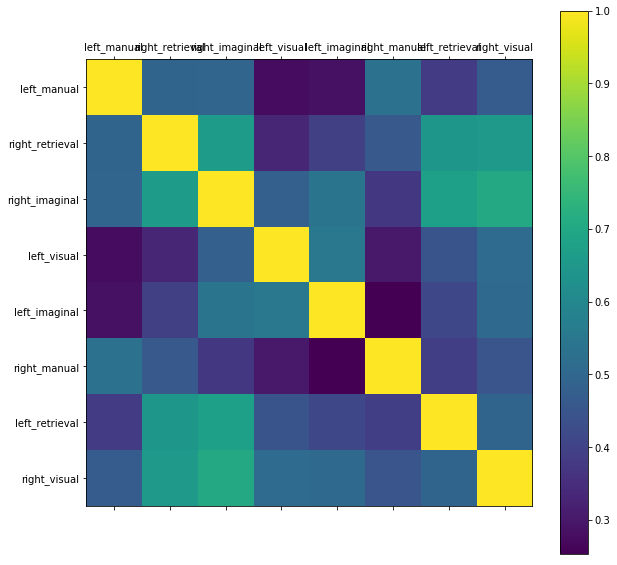

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr())
fig.colorbar(cax)
fig.set_size_inches(10, 10)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

In [30]:
from nilearn.connectome import ConnectivityMeasure

In [31]:
connectome_measure = ConnectivityMeasure(kind='correlation')

In [37]:
X = X.reshape(1, -1, 8)

In [38]:
correlation = connectome_measure.fit_transform(X)

In [40]:
correlation.shape

(1, 8, 8)

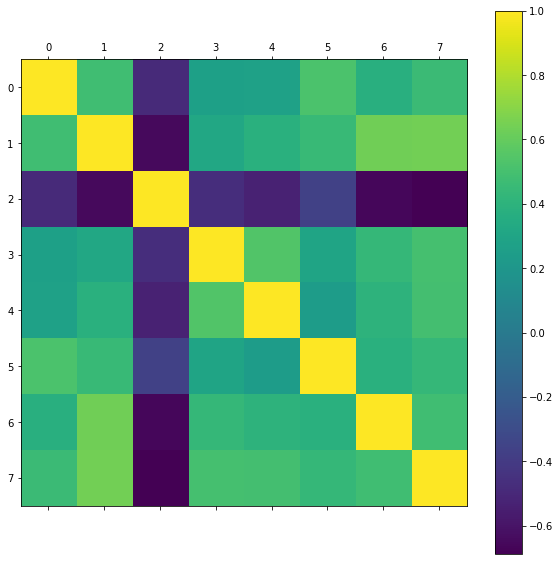

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation[0])
fig.colorbar(cax)
fig.set_size_inches(10, 10)